## Beer Rating Prediction

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

### 1. Data Understanding and Exploration

Let"s first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the dataset
beer = pd.read_csv("train.csv", na_values="NAN")

In [3]:
# Let"s take a look at the first few rows
beer.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


In [4]:
print(beer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
index                37500 non-null int64
beer/ABV             37500 non-null float64
beer/beerId          37500 non-null int64
beer/brewerId        37500 non-null int64
beer/name            37500 non-null object
beer/style           37500 non-null object
review/appearance    37500 non-null float64
review/aroma         37500 non-null float64
review/overall       37500 non-null float64
review/palate        37500 non-null float64
review/taste         37500 non-null float64
review/text          37490 non-null object
review/timeStruct    37500 non-null object
review/timeUnix      37500 non-null int64
user/ageInSeconds    7856 non-null float64
user/birthdayRaw     7856 non-null object
user/birthdayUnix    7856 non-null float64
user/gender          15314 non-null object
user/profileName     37495 non-null object
dtypes: float64(8), int64(4), object(7)
memory usage: 5.4+ MB
None


In [5]:
# Summary of the dataset : 37500 rows, 19 columns

In [6]:
# Renaming the columns
beer = beer.rename(columns={"index":"review_id",})

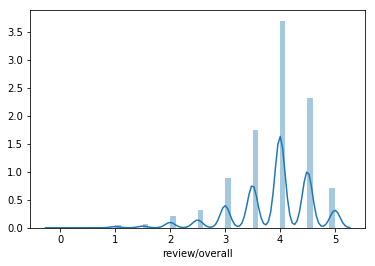

In [7]:
# Distribution of beer review overall isn"t Normally Distributed 
plot1 = sns.distplot(beer["review/overall"])
plot1

In [8]:
# Data is imbalanced
print(beer["review/overall"].value_counts())

4.0    13868
4.5     8666
3.5     6551
3.0     3319
5.0     2671
2.5     1193
2.0      807
1.5      248
1.0      176
0.0        1
Name: review/overall, dtype: int64


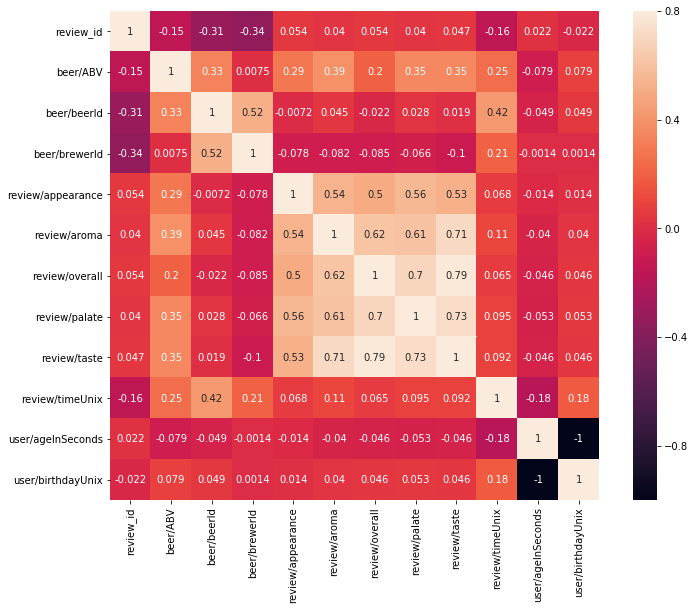

In [9]:
#correlation matrix
corrmat = beer.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True);

# Missing data

Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?
The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [10]:
# Missing data
total = beer.isnull().sum().sort_values(ascending=False)
percent = (beer.isnull().sum()/beer.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
user/birthdayUnix,29644,0.790507
user/birthdayRaw,29644,0.790507
user/ageInSeconds,29644,0.790507
user/gender,22186,0.591627
review/text,10,0.000267
user/profileName,5,0.000133
review/appearance,0,0.000000
beer/ABV,0,0.000000
beer/beerId,0,0.000000
beer/brewerId,0,0.000000


In [11]:
# Dropping columns which aren"t important "user/birthdayUnix","user/birthdayRaw",
# "user/profileName","user/gender","review/timeStruct", "review/timeUnix".

beer.drop(["user/birthdayUnix","user/birthdayRaw","user/profileName","user/gender",
           "review/timeStruct", "review/timeUnix"], axis=1, inplace= True)

# beer["user/gender"].fillna("Missing", inplace=True)

In [12]:
beer["user/ageInSeconds"].fillna(beer["user/ageInSeconds"].mean(), inplace=True)
beer["user/age"] = abs((beer["user/ageInSeconds"]/(365*24*60*60)).astype(int))

beer.drop("user/ageInSeconds", axis=1, inplace= True)

In [13]:
beer["review/text"].fillna("Missing", inplace=True)

In [14]:
beer.head()

,review_id,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,user/age
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,37
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,37
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,37
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,38
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,37


In [15]:
# Missing data
total = beer.isnull().sum().sort_values(ascending=False)
percent = (beer.isnull().sum()/beer.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
user/age,0,0.0
review/text,0,0.0
review/taste,0,0.0
review/palate,0,0.0
review/overall,0,0.0
review/aroma,0,0.0
review/appearance,0,0.0
beer/style,0,0.0
beer/name,0,0.0
beer/brewerId,0,0.0


In [16]:
beer["beer/name"].value_counts()

Founders Breakfast Stout                                1883
Founders KBS (Kentucky Breakfast Stout)                 1441
Founders Centennial IPA                                 1064
Founders Red's Rye PA                                   1051
Founders Dirty Bastard                                   983
Pilsner Urquell                                          947
Founders Double Trouble                                  857
Founders Imperial Stout                                  805
Founders Devil Dancer                                    800
Founders Backwoods Bastard                               778
Founders Porter                                          675
Aecht Schlenkerla Rauchbier MÃ¤rzen                      665
B.O.R.I.S. The Crusher Oatmeal-Imperial Stout            636
Founders Curmudgeon (Old Ale)                            574
Stoudt's Double IPA (India Pale Ale)                     538
Founders Harvest Ale                                     492
Founders CBS Imperial St

In [17]:
len(beer["beer/name"].unique().tolist())

1688

In [18]:
len(beer["beer/style"].unique().tolist())

95

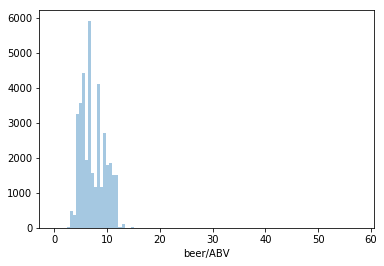

In [19]:
# Distribution of beer review overall isn"t Normally Distributed 
plot2 = sns.distplot(beer["beer/ABV"],kde= False,bins= 100)
plot2

In [20]:
plot3 = sns.histplot(beer["beer/ABV"])
plot3

In [21]:
# types_train = beer.dtypes #type of each feature in data: int, float, object
# num_train = types_train[(types_train == "int64") | (types_train == float)] #numerical values are either type int or float
# cat_train = types_train[types_train == object] #categorical values are type object

In [22]:
# categorical_cols = list(cat_train.index)
# print(categorical_cols)

In [26]:
import re
reviews_raw = beer['review/text']

REPLACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
reviews = [REPLACE.sub("", row.lower()) for row in reviews_raw]

In [27]:
beer["exceptional"] = [1 if 'exceptional' in r else 0 for r in reviews]
beer["excellent"] = [1 if 'excellent' in r else 0 for r in reviews]
beer["exceptional"] = [1 if 'fantastic' in r else 0 for r in reviews]
beer["wonderful"] = [1 if 'wonderful' in r else 0 for r in reviews]
beer["highly"] = [1 if 'highly' in r else 0 for r in reviews]
beer["ok"] = [1 if 'ok' in r else 0 for r in reviews]
beer["average"] = [1 if 'average' in r else 0 for r in reviews]
beer["bad"] = [1 if 'bad' in r else 0 for r in reviews]

In [28]:
X= beer.drop(["review_id", "review/overall", "review/text", "beer/beerId", "beer/brewerId", 
              "beer/name", "user/age"], axis=1)

y= beer["review/overall"]

In [29]:
categorical_cols= ["beer/style"]
X= pd.get_dummies(X, columns= categorical_cols)
X.head()

,beer/ABV,review/appearance,review/aroma,review/palate,review/taste,exceptional,excellent,wonderful,highly,ok,...,beer/style_Scotch Ale / Wee Heavy,beer/style_Scottish Ale,beer/style_Scottish Gruit / Ancient Herbed Ale,beer/style_Smoked Beer,beer/style_Tripel,beer/style_Vienna Lager,beer/style_Weizenbock,beer/style_Wheatwine,beer/style_Winter Warmer,beer/style_Witbier
0,5.0,4.0,4.0,4.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.0,4.0,3.5,3.5,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,3.5,4.0,3.5,3.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.4,3.0,3.0,3.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.4,4.0,3.0,3.5,2.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Building

In [30]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

# MODEL 1 : Linear Regression

In [31]:
alpha = [10 ** x for x in range(-6, 3)]

# initialize Our first XGBoost model...
reg1 = linear_model.LinearRegression()

# declare parameters for hyperparameter tuning
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

# Perform cross validation 
clf = GridSearchCV(reg1,
                    param_grid = parameters,
                    scoring="neg_mean_squared_error",
                    cv=2,
                    n_jobs = -1,
                    verbose = 1)
result = clf.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best: -0.160335 using {'copy_X': True, 'fit_intercept': True, 'normalize': False}
-294492275623372003475456.000000 1(294492275623372003475456.000000) with: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
-0.160335 1(0.001295) with: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
-0.160348 1(0.001289) with: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
-0.160348 1(0.001289) with: {'copy_X': True, 'fit_intercept': False, 'normalize': False}
-294492275623372003475456.000000 1(294492275623372003475456.000000) with: {'copy_X': False, 'fit_intercept': True, 'normalize': True}
-0.160335 1(0.001295) with: {'copy_X': False, 'fit_intercept': True, 'normalize': False}
-0.160348 1(0.001289) with: {'copy_X': False, 'fit_intercept': False, 'normalize': True}
-0.160348 1(0.001289) with: {'copy_X': False, 'fit_intercept': False, 'normalize': False}


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    4.3s finished


In [32]:
lr = linear_model.LinearRegression(copy_X= True, fit_intercept= True, normalize=False)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
pred_train1 = lr.predict(X_train)
pred_target1 = lr.predict(X_test)


rms = sqrt(mean_squared_error(y_test, pred_target1))
print(rms)

0.3971693298479556


In [34]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, pred_target1)
print(r2)

0.674887747499749


# MODEL 2 : XGBoost Regressor

In [35]:
import xgboost as xgb

# initialize Our first XGBoost model...
reg2 = xgb.XGBRegressor(silent=False, random_state=15)

# declare parameters for hyperparameter tuning
parameters = parameters = {'learning_rate':[0.01,0.1],'n_estimators':[200,300,500],'max_depth':[1,2,3]} 


# Perform cross validation 
clf = GridSearchCV(reg2,
                    param_grid = parameters,
                    scoring="neg_mean_squared_error",
                    cv=2,
                    n_jobs = -1,
                    verbose = 1)
result = clf.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_["mean_test_score"]
stds = result.cv_results_["std_test_score"]
params = result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.8min finished


[04:18:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -0.156094 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
-0.430372 1(0.005394) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}
-0.224883 1(0.001604) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 300}
-0.177338 1(0.000660) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
-0.389899 1(0.004889) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
-0.198462 1(0.000962) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}
-0.163090 1(0.000929) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
-0.381307 1(0.005288) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
-0.191902 1(0.001386) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
-0.159110 1(0.000660) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
-

In [36]:
xgb = xgb.XGBRegressor(learning_rate= 0.1, max_depth= 3, n_estimators= 200)
xgb.fit(X_train, y_train)

[04:19:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_train2 = xgb.predict(X_train)
pred_target2 = xgb.predict(X_test)

rms = sqrt(mean_squared_error(y_test, pred_target2))
print(rms)

0.3935040422152104


In [38]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, pred_target2)
print(r2)

0.6808606730765376


In [39]:
# XGBOOST has performed better that's why using it to predict beer rating 

result = pd.DataFrame()
result["y_test"] = y_test
result["y_predicted"] = pred_target2.round(2)
result

,y_test,y_predicted
25970,3.5,3.75
27558,4.5,4.23
25165,4.5,4.38
7052,4.5,3.95
32954,4.0,3.79
27132,2.5,2.95
6431,4.0,3.84
2572,4.0,4.29
37189,1.5,2.25
19514,4.0,4.42


In [40]:
# further we can do feature selection and using impotant features to build the model
# Thank you